In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [ ]:

# Path: data_exploration.ipynb
# Load the dataset rotten_tomatoes_movies.csv in Data folder
df = pd.read_csv("Data/RT/rotten_tomatoes_movies.csv")

# Replace empty strings with NaN
df.replace("", pd.NA, inplace=True)

# Count the number of NaN values in each column
null_counts = df.isna().sum()

# give a percentage of NaN values in each column
null_counts_percent = null_counts / len(df) * 100

# Display the count of NaN values per column
print(null_counts)
print(null_counts_percent)


#create a dataframe that has only the titles for english movies (based on the language column)
df_english = df[df.originalLanguage == "English"]

# Display the first 5 rows of the dataframe
df_english.head()

# Display the number of rows and columns in the dataframe
df_english.shape

#sort the dataframe by the year column

# add a new coloumn called year and extract the year from the release date column that looks like this format: 2018-08-25
df_english["year"] = df_english.releaseDateStreaming.str[:4]

# sort the dataframe by the year column in descending order
df_english.sort_values(by="year", ascending=False, inplace=True)

# remove the null values in the year column
df_english = df_english[df_english.year.notnull()]

# remove the values that older then 2000
df_english = df_english[df_english.year.astype(int) >= 2000]

# dump the dataframe to a csv file
df_english.to_csv("Data/RT/rotten_tomatoes_movies_english_names.csv", index=False)

# give me a list of all the movie titles that are in the dataframe
df_english.title.tolist()

# store it in a text file
with open("Data/Final/rotten_tomatoes_movies_english_title.txt", "w") as f:
    # if its a flaot print it as a float, otherwise print it as a string
    for item in df_english.title.tolist():
        if isinstance(item, float):
            f.write(f"{item}\n")
        else:
            f.write(f"{item}\n")
            




In [ ]:
# lets try this: https://rotten-tomatoes-api.ue.r.appspot.com/movie/bad_boys 
# !pip3 install requests

import requests
import json
import pandas as pd
import time

movies = []

#open the text file and read it line by line and store it in a list for the first 100 movies
with open("Data/Final/rotten_tomatoes_movies_english_title.txt", "r") as f:
    movies = [line.strip() for line in f.readlines()][4300:4400]
f.close()


#loop through the list and make each of them lowercase and also replace space in between words with _
movies = [movie.lower().replace(" ", "_") for movie in movies]


print(movies)

# Create an empty list to store movie data
movie_data = []

# Loop through each movie title
for movie in movies:

    print(f"Scraping {movie}")
    # Create the API url
    url = f'https://rotten-tomatoes-api.ue.r.appspot.com/movie/{movie}'

    # sleep for 1 secs
    time.sleep(1)

    # Make a GET request to the API
    response = requests.get(url)

    print(response.text)

    # if it returns {"detail":"Not Found"} then skip it or if it says "Internal Server Error" then skip it
    if response.text == '{"detail":"Not Found"}' or response.text == "Internal Server Error":
        continue

    # Convert the response JSON into a Python dictionary
    data = json.loads(response.text)

    # print movie hAS BEEN APPENDED
    print(f"{movie} has been appended")

    # Append the movie data to the list
    movie_data.append(data)

# Create a dataframe from the list of dictionaries
df = pd.DataFrame(movie_data)

# Display the dataframe
df.head()

#append in a csv file if it doesnt exist
df.to_csv("Data/Final/4k-5k.csv", mode="a", header=False)

In [ ]:
# Load the dataset output_with_movie_data.csv in Data folder
df = pd.read_csv("Data/Final/output_with_movie_data_NAN.csv")

# Replace 0's with NaN
df.replace(0, pd.NA, inplace=True)

# Count the number of NaN values in each column
null_counts = df.isna().sum()

# give a percentage of NaN values in each column
null_counts_percent = null_counts / len(df) * 100

# Display the count of NaN values per column
print(null_counts)

# Display the count of NaN values per column
print(null_counts_percent)

In [ ]:
import requests
import json
import pandas as pd
import time
from tqdm import tqdm
import os

start_movie_index = 8000  # Modify this as needed
end_movie_index = 10000  # Modify this as needed

# Define the checkpoint interval
checkpoint_interval = 100

# Define the folder to store checkpoint files
checkpoint_folder = "Data/Final/Checkpoints"

# Ensure the checkpoint folder exists
os.makedirs(checkpoint_folder, exist_ok=True)

# Function to load movies from file
def load_movies(filepath, start_index, end_index):
    with open(filepath, "r") as f:
        movies = [line.strip() for line in f.readlines()][start_index:end_index]
    return movies

# Function to save data to CSV in a folder
def save_to_csv(data, folder, filename):
    if not data:
        return  # If no data, don't save
    df = pd.DataFrame(data)
    filepath = os.path.join(folder, filename)
    df.to_csv(filepath, mode="a", header=not os.path.exists(filepath), index=False)

# Load movies and prepare the list
movies = load_movies("Data/Final/rotten_tomatoes_movies_english_title.txt", start_movie_index, end_movie_index)
movies = [movie.lower().replace(" ", "_") for movie in movies]

# Create an empty list to store movie data
movie_data = []

# Initialize progress bar
pbar = tqdm(total=end_movie_index-start_movie_index, desc="Scraping movies", unit="movie")

# Loop through each movie title
for i, movie in enumerate(movies, start=start_movie_index):
    try:
        url = f'https://rotten-tomatoes-api.ue.r.appspot.com/movie/{movie}'
        time.sleep(1)
        response = requests.get(url)

        if response.text == '{"detail":"Not Found"}' or "Internal Server Error" in response.text:
            pbar.update(1)
            continue
        data = json.loads(response.text)

        # Append the movie data to the list
        movie_data.append(data)

        # Save a checkpoint every 'checkpoint_interval' movies
        if (i+1) % checkpoint_interval == 0 or i+1 == end_movie_index:
            checkpoint_filename = f"movies_{i+1-checkpoint_interval}-{i+1}.csv"
            save_to_csv(movie_data, checkpoint_folder, checkpoint_filename)
            movie_data = []  # Reset the list after saving

    except Exception as e:
        print(f"An error occurred while scraping {movie}: {e}")
        continue  # Skip to the next movie

    finally:
        pbar.update(1)

# Save any remaining movie data to CSV
if movie_data:
    checkpoint_filename = f"movies_{end_movie_index-len(movie_data)+1}-{end_movie_index}.csv"
    save_to_csv(movie_data, checkpoint_folder, checkpoint_filename)

pbar.close()
print("Scraping complete. Data saved.")


In [ ]:
# ?Merging files inside Checkpoints folder into one file called output_movies_data_4k-10k.csv
# Also keep in mind that the first file in the folder will have the header, so we need to remove the header from the rest of the files

import pandas as pd
import os

# Define the folder to store checkpoint files
checkpoint_folder = "Data/Final/Output/"

# Get all the files in the folder
files = os.listdir(checkpoint_folder)

# Sort the files by name
files.sort()

# Create an empty list to store the dataframes
dfs = []

# Loop through each file
for file in files:
    # Skip the file if it's not a CSV file
    if not file.endswith(".csv"):
        continue

    # Read the CSV file
    df = pd.read_csv(os.path.join(checkpoint_folder, file))

    # Append the dataframe to the list
    dfs.append(df)

# Concatenate all the dataframes into one
df = pd.concat(dfs)

# Save the dataframe to a CSV file
df.to_csv("Data/Final/output_movies_data_0-35k.csv", index=False)




In [ ]:

#open the file again and add the firest column as index
df = pd.read_csv("Data/Final/output_movies_data_4k-35k.csv", index_col=0)

# append a index column to the start of the dataframe concat
df.reset_index(inplace=True)


# Display the dataframe
df.head()

#save the dataframe to a csv file
df.to_csv("Data/Final/output_movies_data_4k-35k.csv", index=False)

In [10]:
from collections import defaultdict
import csv
# namesDict contains the names mapped to a tuple where other scores are set to zero
namesDict = defaultdict(tuple)

def findMax(lst):
    lst = [float(i) for i in lst]
    # set all values to zero exept the max value
    # maxVal = max(lst)
    # lst = [maxVal if i == maxVal else 0 for i in lst]
    return tuple(lst)

# open file and load movies into dictionary
datafile = "Data/Final/Ethnicity/cast_ethnicity.csv"
with open(datafile, "r", encoding="utf-8") as file:
    reader = csv.reader(file, delimiter=',')
    header = next(reader)
    for row in reader:
        namesDict[row[0]] = findMax(row[2:])

print(namesDict['Jim Parsons'])
print(namesDict['Danny Pudi'])
print(namesDict['Ashley Nicole Williams'])

# for these actors ['Ray Danton', 'Karen Steele', 'Elaine Stewart', 'Jesse White', 'Simon Oakland']  in namesDict, find the diversity score where each value in the tuple is the diversity score in this order 2PRACE,Hispanic,API,Black,AIAN,White;


(0.0010145862784897, 0.0008803742187159, 0.0070558589893162, 0.001102787675846, 0.9896224111373222)
(0.0243203203274065, 0.3063599395926951, 0.0030265062687328, 0.0001650013002641, 0.6660748077447617)
(0.0055952683163135, 0.001107318449716, 0.2031604500258714, 0.0023604732217688, 0.7869549775188083)


In [ ]:
newdf = pd.read_csv("Data/Final/output_movies_data_0-35k.csv")

# sort it by the year column
newdf.sort_values(by="year", ascending=False, inplace=True)

newdf.head()


# Save it to a csv file with the year column
newdf.to_csv("Data/Final/output_movies_data_0-35k_by_year.csv", index=False)

# remove all the movies that are older then 2000
newdf = newdf[newdf.year.astype(int) >= 2000]

# Save it to a csv file with the year column
newdf.to_csv("Data/Final/output_movies_data_0-35k_by_year_2000+.csv", index=False)

In [13]:
def calculate_diversity_score(data):
    # Sum the scores for each ethnicity
    sums = [sum(category) for category in zip(*data.values())]
    total = sum(sums)
    
    # Calculate the proportions and their squares
    proportions = [s / total for s in sums]
    squared_proportions = [p**2 for p in proportions]
    
    # Calculate Gini impurity
    gini_impurity = sum(squared_proportions)
    
    # Calculate the diversity score as 1 - Gini impurity
    diversity_score = 1 - gini_impurity 
    return diversity_score

# Dictionary for actor scores
"['Michelle Yeoh', 'Stephanie Hsu', 'Ke Huy Quan', 'James Hong', 'Jamie Lee Curtis']"

# Test 1, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.9995
# Test 2, 0.0001, 0.0001, 0.0001, 0.0001, 0.9995, 0.0001
# Test 3, 0.0001, 0.0001, 0.0001, 0.9995, 0.0001, 0.0001
# Test 4, 0.0001, 0.0001, 0.9995, 0.0001, 0.0001, 0.0001
# Test 5, 0.0001, 0.9995, 0.0001, 0.0001, 0.0001, 0.0001
# Test 6, 0.9995, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001  

# actor_scores = {
#     'Michelle Yeoh': namesDict['Michelle Yeoh'],
#     'Stephanie Hsu': namesDict['Stephanie Hsu'],
#     'Ke Huy Quan': namesDict['Ke Huy Quan'],
#     'James Hong': namesDict['James Hong'],
#     'Jamie Lee Curtis': namesDict['Jamie Lee Curtis']
# }

# print(namesDict['Michelle Yeoh'])
# print(namesDict['Stephanie Hsu'])
# print(namesDict['Ke Huy Quan'])
# print(namesDict['James Hong'])
# print(namesDict['Jamie Lee Curtis'])
actor_scores = {
    'Test 1': namesDict['Test 1'],
    'Test 2': namesDict['Test 2'],
    'Test 3': namesDict['Test 3'],
    'Test 4': namesDict['Test 4'],
    'Test 5': namesDict['Test 5']
}



# Calculate the movie's diversity score
movie_diversity_score = calculate_diversity_score(actor_scores)
print("The movie's diversity score is:", movie_diversity_score)


The movie's diversity score is: 1


In [ ]:
# MODIFIED GINI

def calculate_diversity_score(data):
    # Calculate the average probability for each ethnicity across all actors
    average_probabilities = [sum(category) / len(data) for category in zip(*data.values())]
    
    # Calculate the total squared deviation from the average for each ethnicity across all actors
    total_squared_deviation = sum(
        (actor_probs[i] - avg_prob) ** 2
        for i, avg_prob in enumerate(average_probabilities)
        for actor_probs in data.values()
    )
    
    # The maximum squared deviation for any actor would be if they had a probability of 1 for an ethnicity,
    # and the average probability would be 1/number of actors for that ethnicity
    max_deviation = sum((1 - (1 / len(data))) ** 2 for _ in average_probabilities)

    # Normalize the total squared deviation to get the diversity score
    diversity_score = 1 - (total_squared_deviation / max_deviation)
    return diversity_score


# The namesDict should contain actual data for each actor's ethnicity
actor_scores = {
    'Test 1': namesDict['Test 1'],
    'Test 2': namesDict['Test 2'],
    'Test 3': namesDict['Test 3'],
    'Test 4': namesDict['Test 4'],
    'Test 5': namesDict['Test 5'],
}

# actor_scores = {
#     'Michelle Yeoh': namesDict['Michelle Yeoh'],
#     'Stephanie Hsu': namesDict['Stephanie Hsu'],
#     'Ke Huy Quan': namesDict['Ke Huy Quan'],
#     'James Hong': namesDict['James Hong'],
#     'Jamie Lee Curtis': namesDict['Jamie Lee Curtis']
# }

print(namesDict['Michelle Yeoh'])
print(namesDict['Stephanie Hsu'])
print(namesDict['Ke Huy Quan'])
print(namesDict['James Hong'])
print(namesDict['Jamie Lee Curtis'])


# Calculate the movie's diversity score
movie_diversity_score = calculate_diversity_score(actor_scores)
print("The movie's diversity score is:", movie_diversity_score)


In [7]:
import pandas as pd
import numpy as np
import ast

newdf = pd.read_csv("Data/Final/diversity_test.csv")

# for each movie get the array of actors name and put them in the actor_scores dictionary and then call the function calculate_diversity_score(actor_scores) and store the result in a new column called diversity_score

# Create a dictionary to store the actor scores
def calculate_diversity_score(actor_data):
  
    # Convert actor_scores to data format
    data = {
        "Name": [],
        "Hispanic": [],
        "API": [],
        "Black": [],
        "AIAN": [],
        "White": []
    }

    mapping = {
        0: "Hispanic",
        1: "API",
        2: "Black",
        3: "AIAN",
        4: "White"
    }
   
    for actor, scores in actor_data.items():
        data["Name"].append(actor)  # Add actor name to the Name list
        for idx, score in enumerate(scores):
            data[mapping[idx]].append(score)  # Add the score to the respective list

    

    # Now data dictionary will be in the desired format with names and corresponding scores

    # Create a DataFrame from the provided data
    df = pd.DataFrame(data)
    df.set_index('Name', inplace=True)

    # Calculate the mean proportion for each ethnicity
    mean_proportions = df.mean(axis=0)

    # Calculate the Shannon diversity index
    shannon_diversity_index = -sum(mean_proportions * np.log(mean_proportions))

    # Normalize the Shannon diversity index to a scale from 0 to 1
    max_shannon_index = np.log(len(mean_proportions))
    normalized_shannon_diversity_index = shannon_diversity_index / max_shannon_index

    # Print the normalized Shannon diversity score
    print(f"The normalized Shannon diversity score is: {normalized_shannon_diversity_index}")

    return normalized_shannon_diversity_index

# Loop through each movie
for index, row in newdf.iterrows():
    # Get the movie name
    movie = row["name"]
    
    # Get the actor names
    # actors = row["actors"][1:-1].split(",")
    string_list = ast.literal_eval(row["actors"])

    actors = [x.strip() for x in string_list]
    
    
    
    actor_scores = {}
    isComplete = True
    for actor in actors:
        actor_scores[actor] = namesDict[actor]
        if namesDict[actor] == ():
            isComplete = False 



    print(actor_scores, isComplete)
    if isComplete:
        diversity_score = calculate_diversity_score(actor_scores)
    # print(diversity_score
    # Add the diversity score to the dataframe for the movie row with the header
        newdf.loc[index, "diversity_score"] = diversity_score
    else:
        # newdf.loc[index, "diversity_score"] = -1
        newdf.drop(index, inplace=True)
        continue


    # Get the actor scores from the namesDict
    # scores = [namesDict[actor] for actor in actors]
    
    # # Add the actor scores to the dictionary
    # actor_scores[movie] = scores

# Display the dataframe
newdf.head()

# Calculate the diversity score for each movie
# diversity_scores = [calculate_diversity_score(scores) for scores in actor_scores.values()]

# Add the diversity scores to the dataframe
# newdf["diversity_score"] = diversity_scores

# Given actor_scores format (assuming it's filled with the correct structure you mentioned)
# actor_scores = {
#     'Michelle Yeoh': namesDict['Michelle Yeoh'],
#     'Stephanie Hsu': namesDict['Stephanie Hsu'],
#     'Ke Huy Quan': namesDict['Ke Huy Quan'],
#     'James Hong': namesDict['James Hong'],
#     'Jamie Lee Curtis': namesDict['Jamie Lee Curtis']
# }



# dump the data into a new csv file
newdf.to_csv("Data/Final/diversity_movies.csv", index=False)

newdf.head(20)


{'Leah Gibson': (0.003925134733183, 0.0017958858839591, 0.0602879177258342, 0.002015212713806, 0.9314063721099666), 'Jonathan Rhys-Meyers': (0.0819548599565842, 0.0261545111844425, 0.0381029127565011, 0.0018808661574999, 0.8513016741051839), 'Jon Voight': (0.0030181003755437, 0.0019358168702299, 0.0010778958542568, 0.0003188974492584, 0.9933557732471298), 'Anthony Konechny': (0.0211579738097153, 0.0057488378408611, 0.0134997974239828, 0.0005396236594709, 0.958866714998188), 'Sebastien Roberts': (0.0033336360180627, 0.0020499242259669, 0.0528965246261393, 0.0018553838919792, 0.9390197436489062)} True
The normalized Shannon diversity score is: 0.19105683364510853
{'Alexander Molony': (0.0011291434058659, 0.0037633404734484, 0.0014441664193178, 0.0022023722782542, 0.9910207016189192), 'Ever Anderson': (0.0423514829743525, 0.0060709835674521, 0.0663932978025158, 0.0027519382986367, 0.881539574139484), 'Jude Law': (0.0055763887388599, 0.1525590588952187, 0.0888436966314844, 0.00104709987918

name  tomatometer  \
0                                               Mercy            0   
1                                   Peter Pan & Wendy           64   
2                                            Stan Lee           81   
3                       Still: A Michael J. Fox Movie           99   
4        Hell House LLC Origins: The Carmichael Manor           83   
5                                    Desperation Road           69   
6                                       Common Ground           70   
7                       Still: A Michael J. Fox Movie           99   
8                                   Peter Pan & Wendy           64   
10                                   Summoning Sylvia          100   
11         The Ringleader: The Case of the Bling Ring           83   
12                                          Freelance            0   
13                                  The Starling Girl           92   
14                                           Mob Land           50   
15                                          Awareness           13   
16  Scout's Honor: The Secret Files of the Boy Sco...           94   
17                      Still: A Michael J. Fox Movie           99   
18  Aliens Abducted My Parents and Now I Feel Kind...           87   
19                                             Unseen           82   
20                                        Oppenheimer           93   

    audience_score  weighted_score                                     genres  \
0               20               6           ['Action', 'Mystery & Thriller']   
1               11              46  ['Kids & Family', 'Fantasy', 'Adventure']   
2               84              82               ['Documentary', 'Biography']   
3               95              97               ['Documentary', 'Biography']   
4               86              84                                 ['Horror']   
5               86              74           ['Action', 'Mystery & Thriller']   
6              100              80                  ['Documentary', 'Nature']   
7               95              97               ['Documentary', 'Biography']   
8               11              46  ['Kids & Family', 'Fantasy', 'Adventure']   
10              87              95             ['Comedy', 'Horror', 'LGBTQ+']   
11              38              68                   ['Crime', 'Documentary']   
12              76              25                       ['Action', 'Comedy']   
13              98              94                                  ['Drama']   
14              77              58  ['Action', 'Mystery & Thriller', 'Crime']   
15              47              24           ['Sci-Fi', 'Mystery & Thriller']   
16              81              89                   ['Crime', 'Documentary']   
17              95              97               ['Documentary', 'Biography']   
18              80              84      ['Comedy', 'Kids & Family', 'Sci-Fi']   
19              71              78           ['Horror', 'Mystery & Thriller']   
20              91              92          ['History', 'Drama', 'Biography']   

   rating duration  year                                             actors  \
0       R   1h 25m  2023  ['Leah Gibson', 'Jonathan Rhys-Meyers', 'Jon V...   
1      PG   1h 46m  2023  ['Alexander Molony', 'Ever Anderson', 'Jude La...   
2     NaN   1h 26m  2023  ['Stan Lee', 'David Gelb', 'Jason Sterman', 'D...   
3       R   1h 35m  2023  ['Michael J. Fox', 'Tracy Pollan', 'Andrew Bar...   
4     NaN   1h 37m  2023  ['James Liddell', 'Gideon Berger', 'Darin F. E...   
5       R   1h 52m  2023  ['Garrett Hedlund', 'Willa Fitzgerald', 'Mel G...   
6     NaN   1h 45m  2023  ['Laura Dern', 'Jason Momoa', 'Rosario Dawson'...   
7       R   1h 35m  2023  ['Michael J. Fox', 'Tracy Pollan', 'Andrew Bar...   
8      PG   1h 46m  2023  ['Alexander Molony', 'Ever Anderson', 'Jude La...   
10      R   1h 14m  2023  ['Travis Coles', 'Michael Urie', 'Frankie Gran...   
11    N

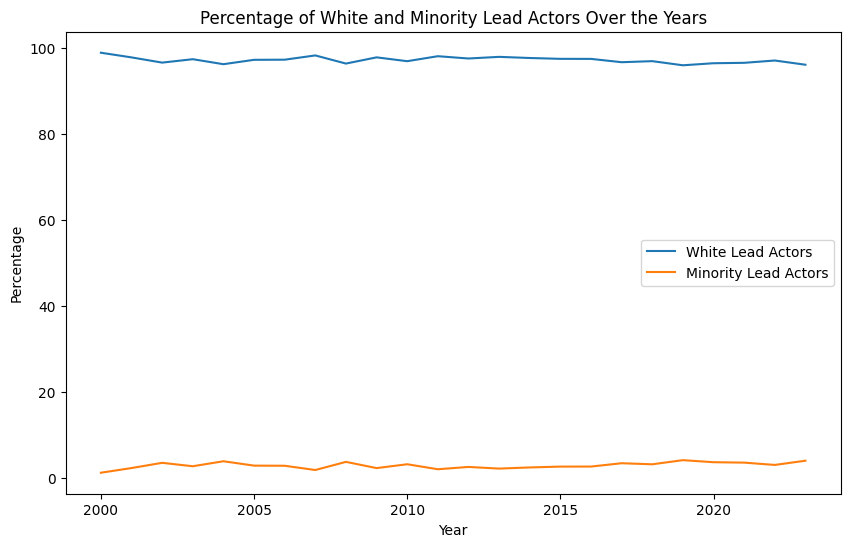

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Example function for getting ethnicity scores (replace with your actual function)
def get_ethnicity_scores(actor):
    # Your implementation here
    # print(actor)

    return namesDict[actor]

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Data\Final\output_movies_data_0-35k_by_year_2000+.csv')

# Calculate the percentage of white lead actors and minority actors for each year
# print(df['actors'])
# convert df['actors'] to a list of strings
df['actors'] = df['actors'].apply(lambda x: ast.literal_eval(x))

# print(df['actors'])
# string_list = ast.literal_eval(row["actors"])

# actors = [x.strip() for x in string_list]


df['White'] = df['actors'].apply(lambda actors: max((get_ethnicity_scores(actor)[-1] if namesDict[actor]!= () else 0) for actor in actors))
df['Minority'] = 1 - df['White']

# Group by year and calculate the mean percentage for each group
grouped_data = df.groupby('year').mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(grouped_data.index, grouped_data['White'] * 100, label='White Lead Actors')
plt.plot(grouped_data.index, grouped_data['Minority'] * 100, label='Minority Lead Actors')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of White and Minority Lead Actors Over the Years')

# Add a legend
plt.legend()

# Show the plot
plt.show()

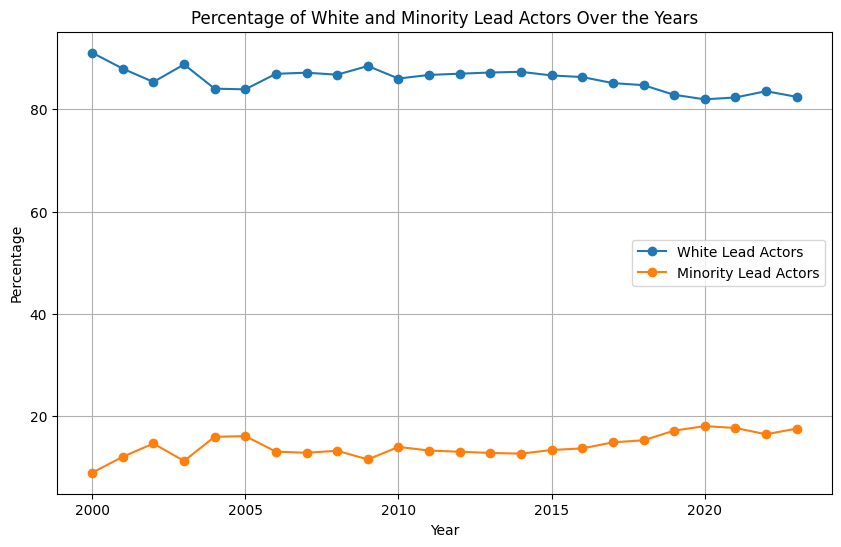

In [29]:

# Example function for getting ethnicity scores (replace with your actual function)
def get_ethnicity_scores(actor):
    # Your implementation here
    # Assuming namesDict is a dictionary containing actors' ethnicity scores
    return namesDict[actor]

# Load your data
df = pd.read_csv('Data/Final/output_movies_data_0-35k_by_year_2000+.csv')

# Ensure the actors column is a list of strings (if necessary)
df['actors'] = df['actors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Calculate the percentage of white lead actors and minority actors for each year
# Here, make sure the calculation reflects the correct percentages
# This part of the code may need to be adjusted based on your actual function and what it returns
df['White'] = df['actors'].apply(lambda actors: sum((get_ethnicity_scores(actor)[-1] if namesDict[actor]!= () else 0) for actor in actors if actor in namesDict))
df['Minority'] = df['actors'].apply(lambda actors: sum(1-(get_ethnicity_scores(actor)[-1] if namesDict[actor]!= () else 0) for actor in actors if actor in namesDict))

# Normalize the counts to get percentages if necessary
# This will depend on what `get_ethnicity_scores` returns
df['White'] = df['White'] / df['actors'].apply(len)
df['Minority'] = df['Minority'] / df['actors'].apply(len)

# Group by year and calculate the mean percentage for each group
grouped_data = df.groupby('year').mean()

# Plot the data with markers for each percentage point
plt.figure(figsize=(10, 6))
plt.plot(grouped_data.index, grouped_data['White'] * 100, marker='o', label='White Lead Actors')
plt.plot(grouped_data.index, grouped_data['Minority'] * 100, marker='o', label='Minority Lead Actors')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of White and Minority Lead Actors Over the Years')

# Add a legend
plt.legend()

# Show the plot with gridlines for better readability
plt.grid(True)
plt.show()


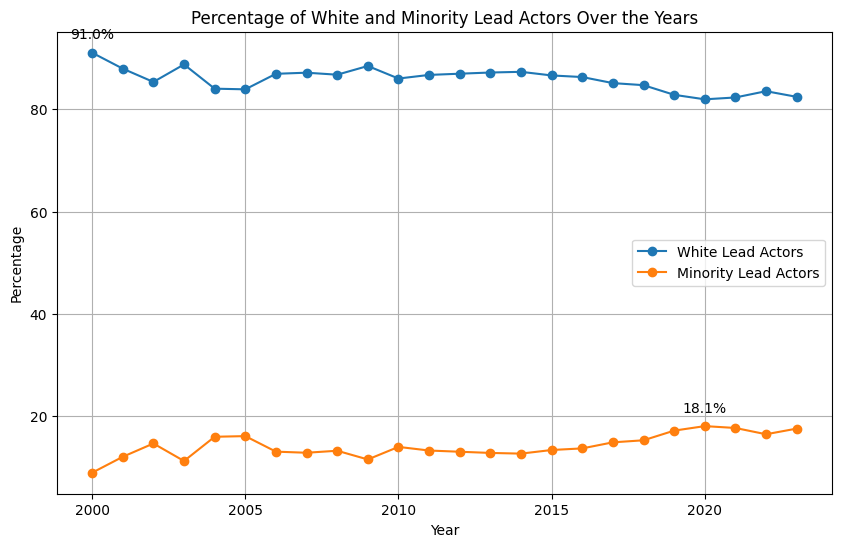

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Example function for getting ethnicity scores (replace with your actual function)
def get_ethnicity_scores(actor):
    # Your implementation here
    # Assuming namesDict is a dictionary containing actors' ethnicity scores
    return namesDict[actor]

# Load your data
df = pd.read_csv('Data/Final/output_movies_data_0-35k_by_year_2000+.csv')

# Ensure the actors column is a list of strings (if necessary)
df['actors'] = df['actors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Calculate the percentage of white lead actors and minority actors for each year
# Here, make sure the calculation reflects the correct percentages
# This part of the code may need to be adjusted based on your actual function and what it returns
df['White'] = df['actors'].apply(lambda actors: sum((get_ethnicity_scores(actor)[-1] if namesDict[actor]!= () else 0) for actor in actors if actor in namesDict))
df['Minority'] = df['actors'].apply(lambda actors: sum(1-(get_ethnicity_scores(actor)[-1] if namesDict[actor]!= () else 0) for actor in actors if actor in namesDict))

# Normalize the counts to get percentages if necessary
# This will depend on what `get_ethnicity_scores` returns
df['White'] = df['White'] / df['actors'].apply(len)
df['Minority'] = df['Minority'] / df['actors'].apply(len)

# Group by year and calculate the mean percentage for each group
grouped_data = df.groupby('year').mean()

# Plot the data with markers for each percentage point
plt.figure(figsize=(10, 6))
white_line, = plt.plot(grouped_data.index, grouped_data['White'] * 100, marker='o', label='White Lead Actors')
minority_line, = plt.plot(grouped_data.index, grouped_data['Minority'] * 100, marker='o', label='Minority Lead Actors')


# Find the max value for white lead actors and minority lead actors
max_white = grouped_data['White'].max()
max_minority = grouped_data['Minority'].max()

# Get the year for the max values
max_white_year = grouped_data['White'].idxmax()
max_minority_year = grouped_data['Minority'].idxmax()

# Annotate the highest point for white lead actors
plt.annotate(f'{max_white * 100:.1f}%', (max_white_year, max_white * 100),
             textcoords="offset points", xytext=(0,10), ha='center')

# Annotate the highest point for minority lead actors
plt.annotate(f'{max_minority * 100:.1f}%', (max_minority_year, max_minority * 100),
             textcoords="offset points", xytext=(0,10), ha='center')


# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of White and Minority Lead Actors Over the Years')

# Add a legend
plt.legend()

# Show the plot with gridlines for better readability
plt.grid(True)
plt.show()


In [8]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

# Assuming your data is in a CSV file named 'movie_data.csv'
# Replace 'movie_data.csv' with the actual name of your file
df = pd.read_csv('Data/Final/output_movies_data_0-35k_by_year_2000+.csv')

# Verify the column names in your dataset
print(df.columns)

# Extracting relevant columns
X = df[['tomatometer', 'audience_score', 'weighted_score', 'year']]
y = df['diversity_score']

# Adding a constant to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

ModuleNotFoundError: No module named 'statsmodels'

In [3]:
pip install statsmodels

  Using cached statsmodels-0.14.0.tar.gz (19.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'c:\Users\Mohammad Hassan\AppData\Local\Programs\Python\Python38-32\python.exe' 'c:\Users\Mohammad Hassan\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pip' install --ignore-installed --no-user --prefix 'C:\Users\Mohammad Hassan\AppData\Local\Temp\pip-build-env-ss42ievy\overlay' --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- 'setuptools>=59.2.0' 'cython>=0.29.26,<3' 'oldest-supported-numpy; python_version!='"'"'3.10'"'"' or platform_system!='"'"'Windows'"'"' or platform_python_implementation=='"'"'PyPy'"'"'' 'numpy>=1.22.3; python_version=='"'"'3.10'"'"' and platform_system=='"'"'Windows'"'"' and platform_python_implementation != '"'"'PyPy'"'"'' 'numpy; python_version>='"'"'3.12'"'"'' 'scipy>=1.4' 'setuptools_scm[toml]~=7.0.0'
       cwd: None
  Complete output (63 lines):
  Ignoring numpy: markers 'python_version == "3.10" and platform_system == "Windows" and pla